In [8]:
import os
import pandas as pd
from decimal import Decimal
import numpy as np
from datetime import datetime, timedelta
from dotenv import load_dotenv
import yfinance as yf
import math

import matplotlib.pyplot as plt
import plotly.express as px
import pytz  # Make sure to import pytz for timezone handling
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import requests
import csv

import warnings

In [9]:
load_dotenv()

local_inv_directry = os.getenv("local_inv_directry")

e:\Python\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
e:\Python\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  2 of 2 completed


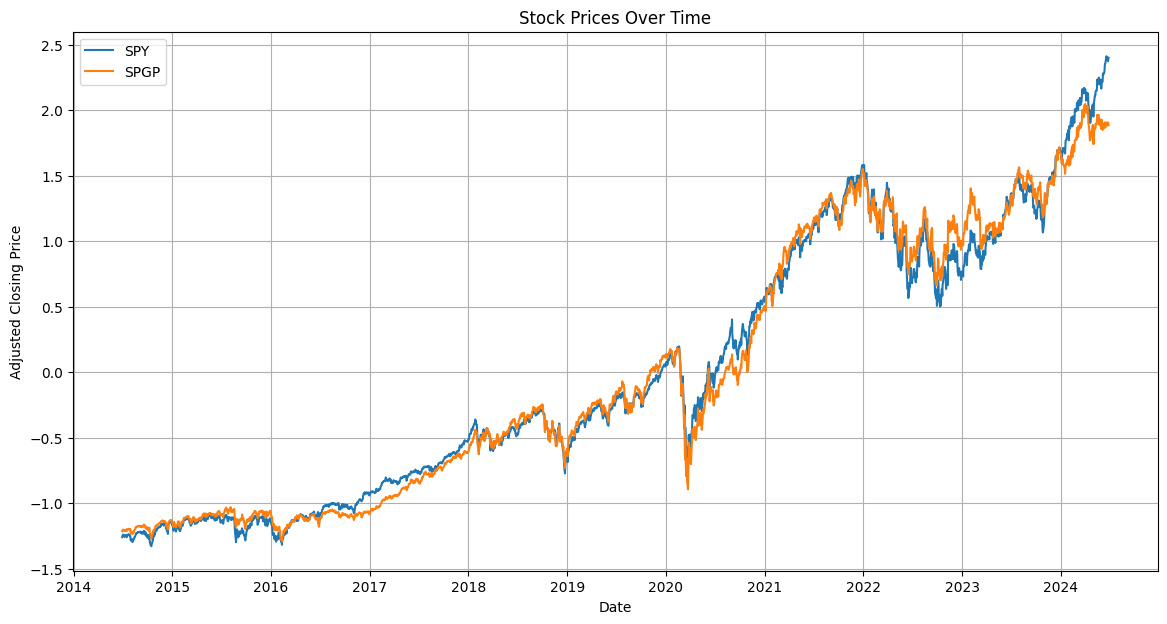

In [13]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

today_date = datetime.today()
window_days = 365*10 # This is 5 years in days window

# Define the list of stock symbols
stocks_list = [
    'SPY'
    ,'SPGP'
    # ,'COST'
    # ,'WMT'

    ]

# Fetch the data
data = yf.download(
    stocks_list
    ,start=today_date - timedelta(days=window_days)
    ,end=today_date)



# The data contains multi-level columns, we'll focus on 'Adj Close' for adjusted closing prices
adj_close = data['Adj Close']

# Perform standardization using StandardScaler
scaler = StandardScaler()
standardized_data = scaler.fit_transform(adj_close)

# Convert the normalized data back to a DataFrame
standardized_data = pd.DataFrame(standardized_data, index=adj_close.index, columns=adj_close.columns)


# Plotting the adjusted closing prices of the stocks
plt.figure(figsize=(14, 7))

for stock in stocks_list:
    plt.plot(standardized_data[stock], label=stock)

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.grid(True)
plt.show()
